In [8]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from textblob import Word, TextBlob
from wordcloud import WordCloud
from nltk import word_tokenize

In [9]:
pd.set_option("display.max_columns",None)
pd.set_option("display.width", 200)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

In [10]:
df_train = pd.read_csv("twitter_training.csv")
df_valid = pd.read_csv("twitter_validation.csv")

In [11]:
df_train.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [12]:
df_train.columns

Index(['2401', 'Borderlands', 'Positive', 'im getting on borderlands and i will murder you all ,'], dtype='object')

In [13]:
df_train.columns=['id','information','status','comment']
df_train.head()

,id,information,status,comment
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [14]:
df_valid.columns=['id','information','status','comment']
df_valid.head()

,id,information,status,comment
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           74681 non-null  int64 
 1   information  74681 non-null  object
 2   status       74681 non-null  object
 3   comment      73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [16]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           999 non-null    int64 
 1   information  999 non-null    object
 2   status       999 non-null    object
 3   comment      999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB


In [17]:
# Check for missing values
missing_values = df_train.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 id               0
information      0
status           0
comment        686
dtype: int64


In [18]:
df_train = df_train.dropna(subset=['comment'])

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73995 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           73995 non-null  int64 
 1   information  73995 non-null  object
 2   status       73995 non-null  object
 3   comment      73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


#### Normalizing Case Folding

In [20]:
df_train["comment"] = df_train["comment"].str.lower()
df_valid["comment"] = df_valid["comment"].str.lower()

#### Punctuations, Urls and other Preprocessing

In [21]:
"""
[@&]\S+ → @mention ve &labels
& → only &
http\S+|www\S+ → URL's
\d+ → Numbers 
[^\w\s] → all Punctuations
\s+ → Fazla boşlukları temizler.
.str.strip() → Baştaki ve sondaki boşlukları kaldırır.
"""
df_train["comment"] = df_train["comment"].str.replace(r"[@&]\S+|&|http\S+|www\S+|[^\w\s]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()
df_valid["comment"] = df_valid["comment"].str.replace(r"[@&]\S+|&|http\S+|www\S+|[^\w\s]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()
df_train["comment"] = df_train["comment"].str.replace(r"[@&]\S+|&|http\S+|www\S+|\d+|[^\w\s]", "", regex=True) \
                                         .str.replace(r"\s+", " ", regex=True) \
                                         .str.strip()

df_valid["comment"] = df_valid["comment"].str.replace(r"[@&]\S+|&|http\S+|www\S+|\d+|[^\w\s]", "", regex=True) \
                                         .str.replace(r"\s+", " ", regex=True) \
                                         .str.strip()


#### Stopwords

In [22]:
nltk.download("stopwords")
sw = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91844\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
df_train["comment"] = df_train["comment"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df_valid["comment"] = df_valid["comment"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

#### Rarewords

In [24]:
temp_df_train = pd.Series(" ".join(df_train["comment"]).split()).value_counts()
temp_df_valid = pd.Series(" ".join(df_valid["comment"]).split()).value_counts()

In [25]:
temp_df_train

game                                                              8066
im                                                                4941
like                                                              4882
get                                                               3941
one                                                               3584
                                                                  ... 
ummmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm       1
novykapadia                                                          1
kdcnrszfq                                                            1
novysir                                                              1
lldevildriver                                                        1
Name: count, Length: 37334, dtype: int64

In [26]:
drop_train = temp_df_train[temp_df_train <= 1]
drop_valid = temp_df_valid[temp_df_valid <= 1]

In [27]:
df_train["comment"] = df_train["comment"].apply(lambda x: " ".join(x for x in x.split() if x not in drop_train))
df_valid["comment"] = df_valid["comment"].apply(lambda x: " ".join(x for x in x.split() if x not in drop_valid))

In [28]:
df_train.head(10)

,id,information,status,comment
0,2401,Borderlands,Positive,coming borders kill
1,2401,Borderlands,Positive,im getting borderlands kill
2,2401,Borderlands,Positive,im coming borderlands murder
3,2401,Borderlands,Positive,im getting borderlands murder
4,2401,Borderlands,Positive,im getting borderlands murder
5,2402,Borderlands,Positive,spent hours making something fun dont know hug...
6,2402,Borderlands,Positive,spent couple hours something fun dont know im ...
7,2402,Borderlands,Positive,spent hours something fun dont know im huge bo...
8,2402,Borderlands,Positive,spent hours making something fun dont know hug...
9,2402,Borderlands,Positive,spent hours making something fun dont know hug...


In [29]:
#Count information per category
plot1=df_train.groupby(by=["information","status"]).count().reset_index()
plot1.head()

,information,status,id,comment
0,Amazon,Irrelevant,186,186
1,Amazon,Negative,575,575
2,Amazon,Neutral,1207,1207
3,Amazon,Positive,308,308
4,ApexLegends,Irrelevant,192,192


c:\Users\91844\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\91844\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\91844\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\91844\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

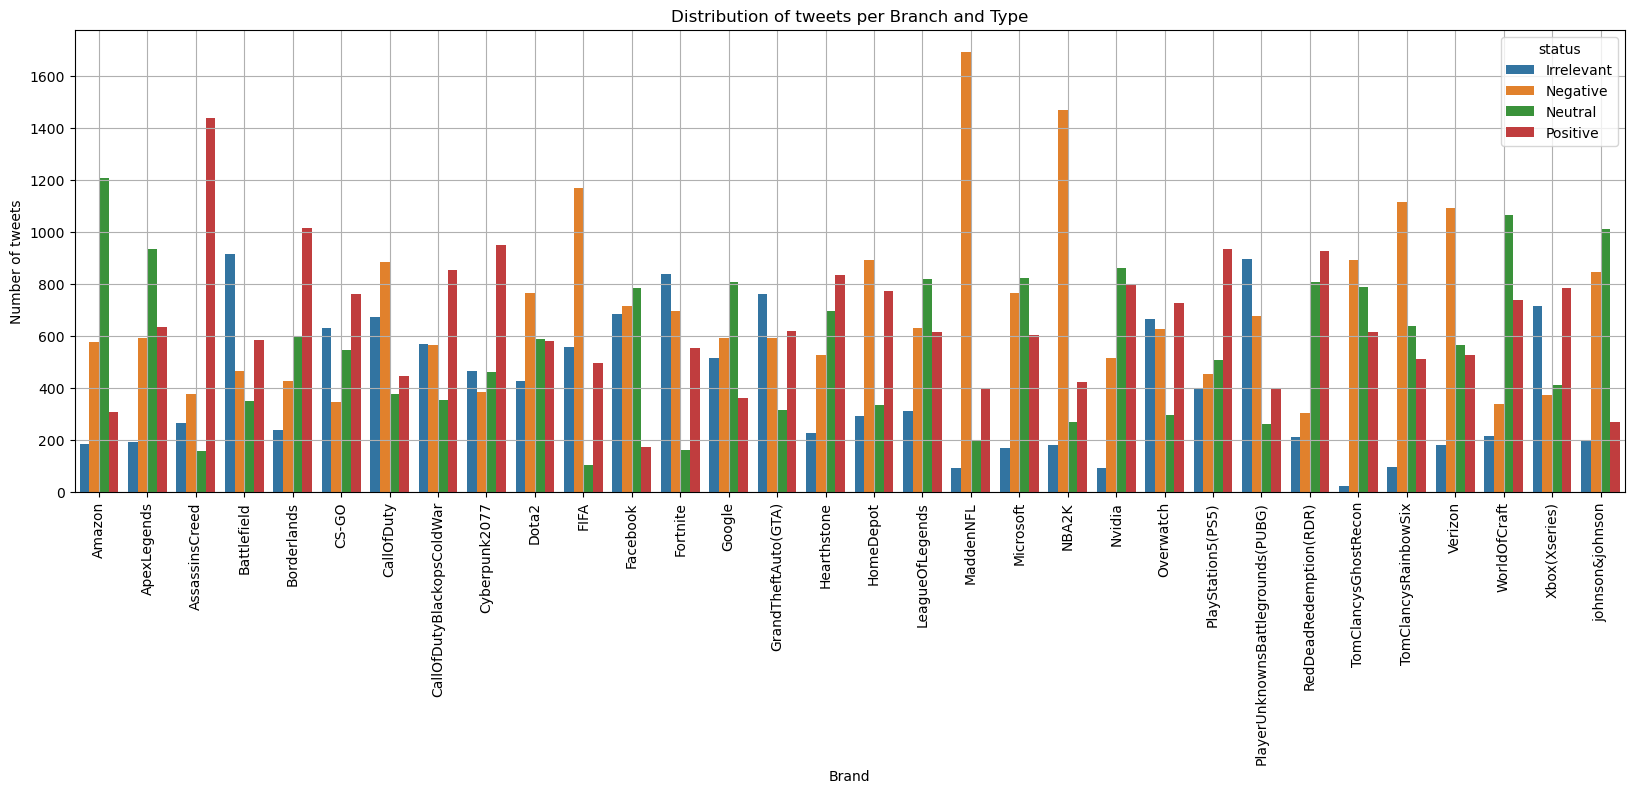

In [30]:
#Figure of comparison per branch
plt.figure(figsize=(20,6))
sns.barplot(data=plot1,x="information",y="id",hue="status")
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Number of tweets")
plt.grid()
plt.title("Distribution of tweets per Branch and Type");

c:\Users\91844\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\91844\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\91844\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


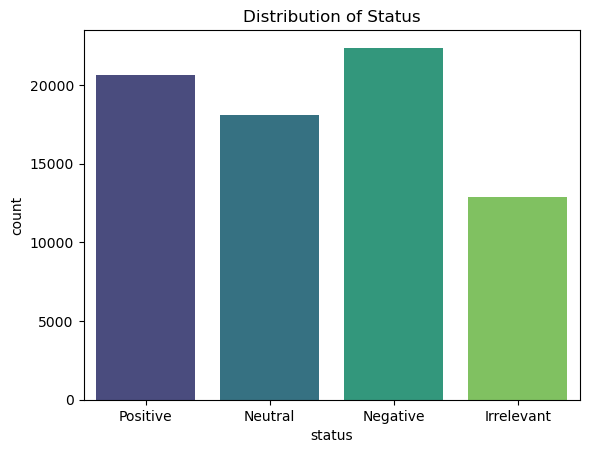

In [31]:
# Sentiment distribution
sns.countplot(x='status', data=df_train, palette='viridis')
plt.title("Distribution of Status")
plt.show()

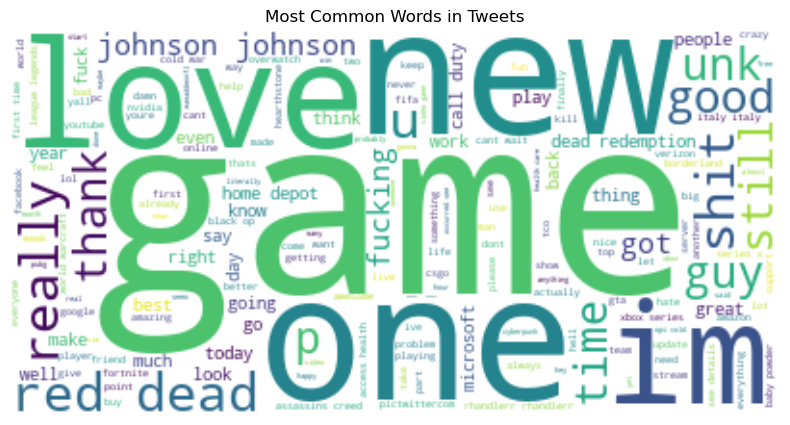

In [32]:
# Wordcloud
text = " ".join(i for i in df_train.comment)
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(12,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Most Common Words in Tweets")
plt.axis("off")
plt.show()

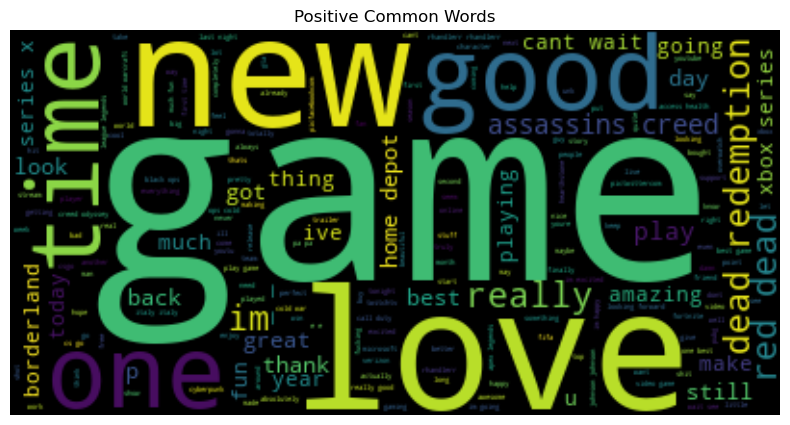

In [33]:
# Wordcloud positive
# "Positive" filter
positive_comments = df_train[df_train["status"] == "Positive"]["comment"]

text_positive = ''.join(i for i in positive_comments)
wordcloud = WordCloud(background_color="black").generate(text_positive)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Positive Common Words")
plt.axis("off")
plt.show()

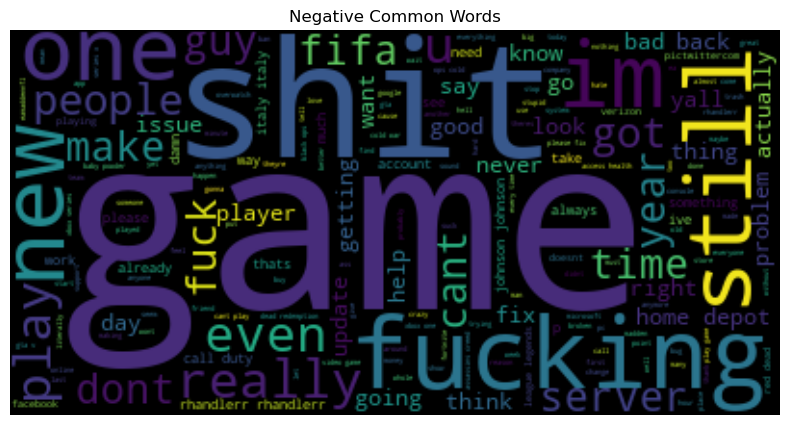

In [34]:
# Wordcloud negative
# "Negative" filter
negative_comments = df_train[df_train["status"] == "Negative"]["comment"]

text_positive = ''.join(i for i in negative_comments)
wordcloud = WordCloud(background_color="black").generate(text_positive)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Negative Common Words")
plt.axis("off")
plt.show()

In [35]:
#Text splitting
tokens_text = [word_tokenize(str(word)) for word in df_train["comment"]]
#Unique word counter
tokens_counter = [item for sublist in tokens_text for item in sublist]
print("Number of tokens: ", len(set(tokens_counter)))

Number of tokens:  25780


In [36]:
# Convert text to numerical features
vectorizer = CountVectorizer(tokenizer=word_tokenize, ngram_range=(1, 2))
X = vectorizer.fit_transform(df_train['comment'])
y = df_train['status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train a simple classifier
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

c:\Users\91844\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\91844\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8947901885262518
              precision    recall  f1-score   support

  Irrelevant       0.94      0.83      0.88      2587
    Negative       0.91      0.92      0.91      4485
     Neutral       0.92      0.87      0.89      3563
    Positive       0.85      0.93      0.89      4164

    accuracy                           0.89     14799
   macro avg       0.90      0.89      0.89     14799
weighted avg       0.90      0.89      0.89     14799



In [37]:
import pickle

# Save the trained model
with open("sentiment_model.pkl", "wb") as model_file:
    pickle.dump(model, model_file)

# Save the vectorizer
with open("vectorizer.pkl", "wb") as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

print("✅ Model and Vectorizer saved successfully!")


✅ Model and Vectorizer saved successfully!
